In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['compositional-abstractions']
coll = db['two-towers']

# which iteration name should we use?
iterationName = 'livetest0'

## look up number of trials
trialNumDict = {'testing':13, 'livetest0':13}
numTrials = trialNumDict[iterationName]

In [8]:
d = conn['curiotower']
coll = d['evalTower']


In [10]:
iterationName = 'livetest0'
coll.distinct('iterationName')

[]

### construct tidy dataframe with game data

### establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

In [6]:
## get list of all gameIDs in database
total_games = coll.find({'iterationName':iterationName}).distinct('gameid')
print('There are {} total games.'.format(len(total_games)))

## get list of complete gameIDs
gameIDs = coll.find({'iterationName':iterationName}).distinct('gameid')
complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
print('There are {} complete games.'.format(len(complete_games)))

There are 2 total games.
There are 1 complete games.


In [ ]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot1',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        #loop over iteration names??
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
#                                  {"$or":[{'iterationName':'Exp2Pilot3'},
#                                  {'iterationName':'Exp2Pilot3_batch2'}]}
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [ ]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


## Full DF from DB

In [65]:
# Ensure one to one gameID and workerId 
# Should only happen if a repeat worker gets through

# query = coll.find({"$and":[
# #                         {'workerId':{'$exists':True}},
# #                         {'condition':{'$ne':'practice'}},
# #                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'testing'}]}]
#                      })

#df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))
#df_trial_end_full[['workerId','gameID']]

query = coll.find()

df_trial_end_full = pd.DataFrame(list(query))

#assert (np.mean(df_trial_end_full['workerId'].value_counts()) == np.mean(df_trial_end_full['gameID'].value_counts()))

KeyboardInterrupt: 

In [ ]:
## How many records?
coll.estimated_document_count()

In [ ]:
#df_trial_end_full.columns

#### check outcome for specific workerID

In [ ]:
#set worker ID
workerID = 'A37XBH865833FE'
iteration = 'pilot0'
#get GameID (not all info available at workerID level (e.g. bonus))
gameID = df_trial_end_full[df_trial_end_full['workerId'] == workerID]['gameid'].unique()[0]

#check iteration name
df_game = df_trial_end_full[(df_trial_end_full['iterationName'] == iteration) &
                            (df_trial_end_full['gameid'] == gameID)]
#get workerIds
print('workerIDS:',df_game['workerId'].unique())
#get bonus for gameID ([air of workerIDs])
print("Bonus:",np.nanmax(df_game['cumulativeBonus']))

In [ ]:
df_trial_end_full[(df_trial_end_full['iterationName'] == 'pilot2')].content.unique()

In [ ]:
#see full history for single worker
df_test = df_trial_end_full[(df_trial_end_full['iterationName'] == iterationName)&
                           (df_trial_end_full['workerId'] == workerID)]
df_test.content.unique()

## Trial Level Data

In [ ]:
# # Assuming that if trial 23 saves, then 0-22 have also saved 
# # get ids of people with trial 23 data
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {'trialNum': numTrials-1}]
#                      })
# complete_data_df = pd.DataFrame(query)
# complete_data_ids = list(complete_data_df['workerId'])

In [ ]:
# # Filter for full datasets
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]}]
#                      })

# df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))


# # filter dataframe for complete datasets
# df_trial_end_full_filtered = df_trial_end_full[df_trial_end_full.workerId.isin(complete_data_ids)]

# # reduce to crucial information
# df_trial_end_reduced_filtered = df_trial_end_full_filtered[[
#     'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID', #trial identifiers
#     'nullScore','F1Score','normedScore','rawScoreDiscrete','nullScoreDiscrete','normedScoreDiscrete','scoreGapDiscrete', #scoring
#     'numBlocks','nPracticeAttempts','blockColor','blockColorID','blockFell','doNothingRepeats',#misc. trial info
#     'score','currBonus','timeBonus', #bonusing
#     'timeAbsolute','timeRelative','buildTime','buildStartTime','buildFinishTime','timeToBuild', #timing 
#     'discreteWorld','allVertices', #world reconstruction
#     'browser','browserVersion','os','devMode', #developer info
#     #below here should be the same for every trial in a dataset
#     'iterationName',
#     'numTargets', 'prePostSetSize','numRepetitions', #pre-post info
#     'bonusThresholdLow','bonusThresholdMid','bonusThresholdHigh','timeThresholdYellow','timeThresholdRed', #bonus info
#     ]]

# #Fix error in data-saving- normedScoreDiscrete saved as rawScoreDiscrete
# df_trial_end_reduced_filtered['normedScoreDiscrete'] = df_trial_end_reduced_filtered['rawScoreDiscrete']
# df_trial_end_reduced_filtered.drop(['rawScoreDiscrete'], axis=1)


# df = df_trial_end_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

## Create DF for each event

In [ ]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/compabs_block_{}.csv'.format(iterationName))
df_chat = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format(iterationName))
df_exit = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format(iterationName))
df_trial = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format(iterationName))

In [6]:
#manually build full df (needs to be generalized)
df_block0 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot0'))
df_chat0 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot0'))
df_exit0 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot0'))
df_trial0 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot0'))
#
df_block1 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot1'))
df_chat1 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot1'))
df_exit1 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot1'))
df_trial1 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot1'))
#
df_block2 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot2'))
df_chat2 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot2'))
df_exit2 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot2'))
df_trial2 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot2'))

df_block = pd.concat([df_block0,df_block1,df_block2])
df_chat = pd.concat([df_chat0,df_chat1,df_chat2])
df_exit = pd.concat([df_exit0,df_exit1,df_exit2])
df_trial = pd.concat([df_trial0,df_trial1,df_trial2])

print("Total Completed Games:",len(df_exit.gameid.unique()))

Total Completed Games: 20


#### Exclusion Criteria

In [64]:
#How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']
print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75[df75['trials']>=9]))

Total dyads achieving 75% Accuracy on 75% of trials: 13


In [71]:
df_exit.confused

0     yes
1     yes
2     yes
3     yes
4     yes
5     yes
6     yes
7     yes
8     yes
9     yes
10    yes
11    yes
12    yes
13    yes
14    yes
15    yes
0     yes
1     yes
2     yes
3     yes
4     yes
5     yes
6     yes
7     yes
8     yes
9     yes
10    yes
11    yes
12    yes
13    yes
14    yes
15    yes
16    yes
17    yes
18    yes
19    yes
20    yes
21    yes
22    yes
Name: confused, dtype: object

In [ ]:
#read in dataframes from each eventType
# block_data = []
# for i in range(0,3):
#     block_data.append(pd.read_csv('../results/csv/compabs_block_pilot{}.csv'.format(i)))
# df_block = pd.concat(block_data)
# df_block =  [pd.merge(pd.read_csv('../results/csv/compabs_block_pilot{}.csv'.format(i))) for i in range(0,3)]
# df_chat = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format(iterationName))
# df_exit = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format(iterationName))
# df_trial = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format(iterationName))

In [7]:
df_block.iterationName.unique()

array(['pilot0', 'pilot2'], dtype=object)

In [8]:
df_exit.comments.unique()

array(['No',
       'All was clear and worked as it should~~~ Thanks for the opportunity~~~',
       'It was a little laggy, but it worked out in the end~~~', nan,
       'no',
       'It was almost impossible to get a bonus because I was unable to place the blocks correctly~~~ I feel that we should still receive a bonus for the time spent on this HIT~~~',
       'Interesting experiment', 'Extremely interesting experiment~~~',
       'No issues that I saw~~~ Thanks!',
       'Yes~~~ This HIT took 72 minutes~~~ You said it would take 25~~~ I feel very deceived~~~',
       'Ir an out of time to submit HIT, you should have given more time~~~',
       'nothing problem', 'no  issue', 'No issues~~~',
       'no, it was fun~~~ It took me a minute to get it~~~',
       'My counterpart was a bot~~~', 'NO', 'good', 'Nothing',
       'No, it was fun, thank you!',
       'No problems, experiment was fun and ran great!',
       'No, it was really fun, thank you!', 'interesting',
       'Clearer ins

#### Total Game Duration (for Gameplay)

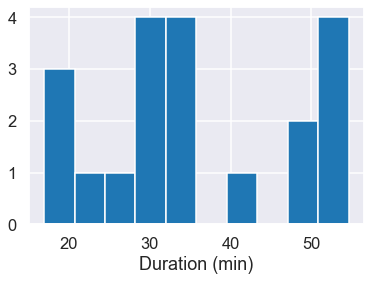

In [9]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

In [10]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).mean()

35.44269333333333

### Inspect some raw data: language

In [11]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [12]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_chat['trialNum'] = pd.to_numeric(df_chat['trialNum'], errors = 'coerce')

In [13]:
#inspect specific chat history of one dyad
dyadGameId = '8548-343a533f-0369-4b20-bbd4-a00f25359cea'
df_chat[(df_chat.gameid == dyadGameId)]['content'].unique()

array(['move left', 'move right\n', 'build the block\n',
       'build the red block\n', 'move the right block to the left',
       'move the lift block to the right\n', 'move the right red',
       'build the blue block', 'bulid the red block',
       'move the right bulid the left', 'move the blue block',
       'move the left block to the right corner',
       'build the block to next blue block',
       'move the red block to the right corner to the blue block',
       'move to left block to right', 'move the next block', 'move right',
       'bulid the right the left block\n', 'move left\n',
       'bulid the right to left block', 'move left to right block',
       'move right to left block ', 'mobe left', 'movbe left'],
      dtype=object)

### Inspect some raw data: display block towers

In [14]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']
floatCols = ['w','h','blockNum','turnNum','x','y']
df_block[floatCols] = df_block[floatCols].applymap(np.int64)

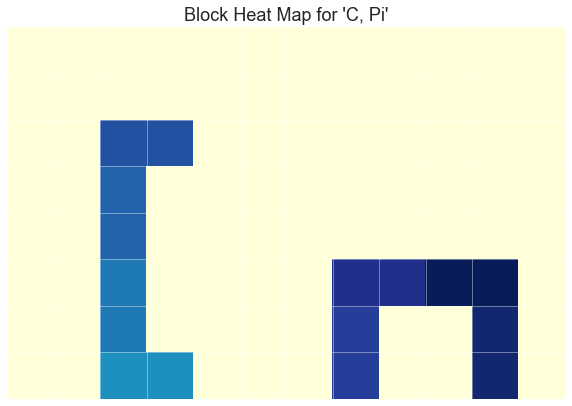

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(df_block[(df_block.leftTarget == 'C') & 
                                           (df_block.rightTarget == 'Pi') &
                                           (df_block.gameid == '0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2')], 
                                  ax, 
                                  world_size = [12,8])
plt.title("Block Heat Map for 'C, Pi'")
plt.show()

## Make basic visualizations and calculate descriptives

### Architect: mean number of words across trials

In [16]:
#Get sum of words for each trial, group by game then average across games
print(df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean())

trialNum
0.0     55.35
1.0     49.50
2.0     38.95
3.0     33.90
4.0     33.00
5.0     28.20
6.0     23.25
7.0     21.60
8.0     19.15
9.0     17.95
10.0    17.90
11.0    17.95
Name: word_count, dtype: float64


Text(0, 0.5, 'Word Count')

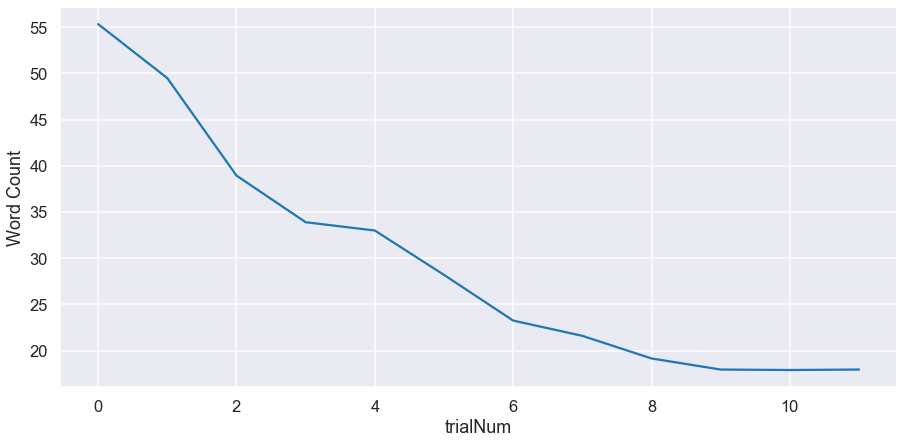

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Word Count')

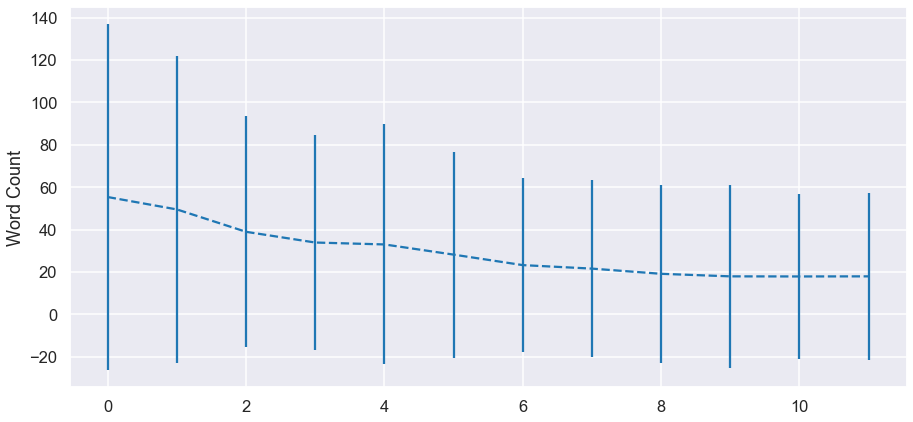

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
mean = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean()
std = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).std()

plt.errorbar(mean.index, mean, yerr=2*std, linestyle='--')
plt.ylabel('Word Count')
plt.show()

In [19]:
## print summary stat to console?

###  Architect: mean number of characters across trials

Text(0, 0.5, 'Char Count')

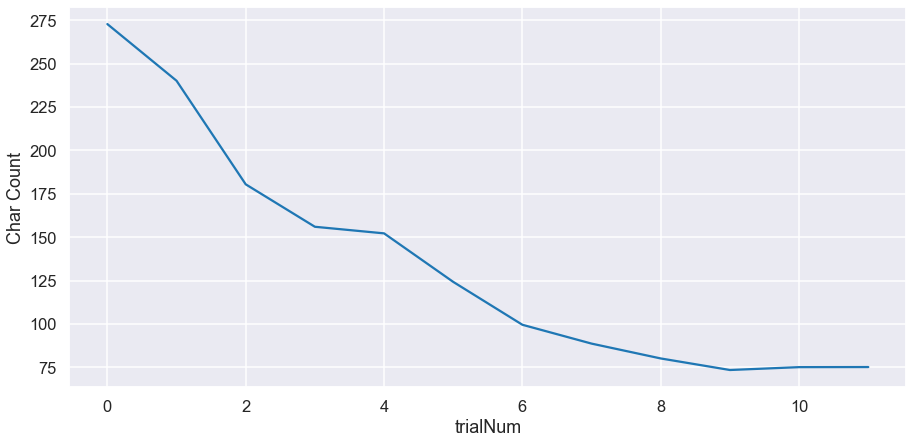

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['char_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Char Count')

### Architect: mean number of messages (across turns within a trial) across trials

Text(0, 0.5, 'Messages per trial')

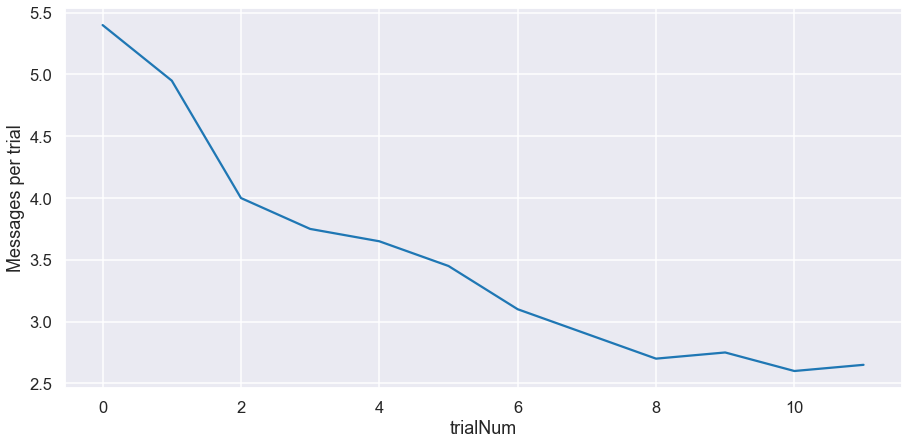

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['_id'].count().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Messages per trial')

### Architect: Total typing time (across turns within at trial) across trials

In [22]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

Text(0, 0.5, 'Average Time elapsed, Architect')

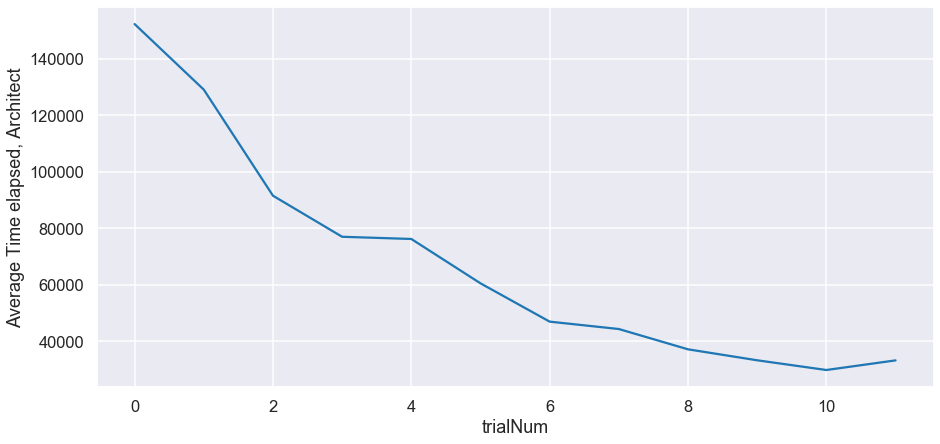

In [23]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [24]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

trialNum
0.0     152317.30
1.0     129113.90
2.0      91571.75
3.0      77040.30
4.0      76259.70
5.0      60563.00
6.0      47003.85
7.0      44389.60
8.0      37205.60
9.0      33323.25
10.0     29886.65
11.0     33289.20
Name: timeElapsedInTurn, dtype: float64

### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

In [25]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

Text(0, 0.5, 'Trial Score')

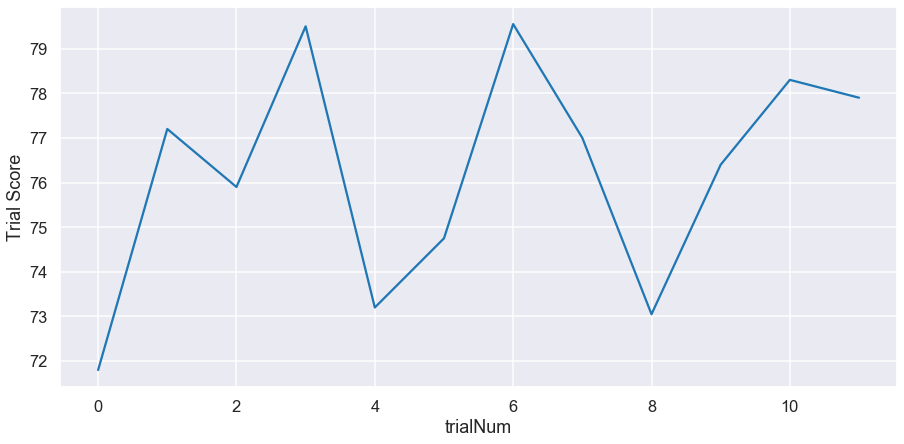

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

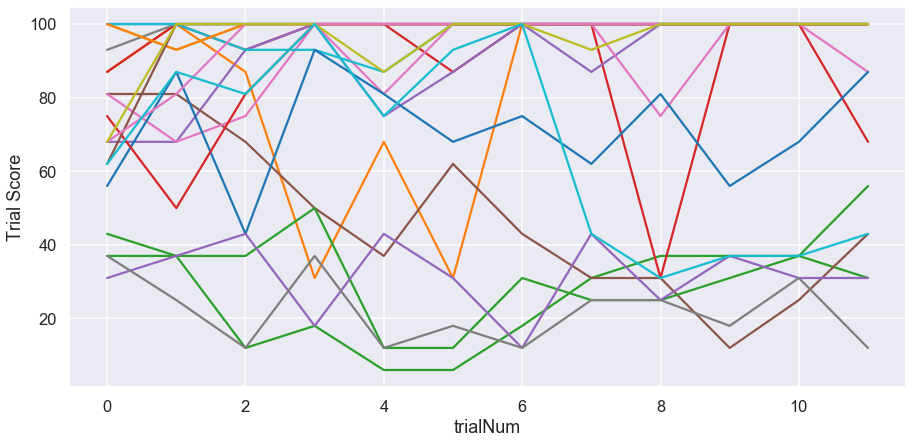

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

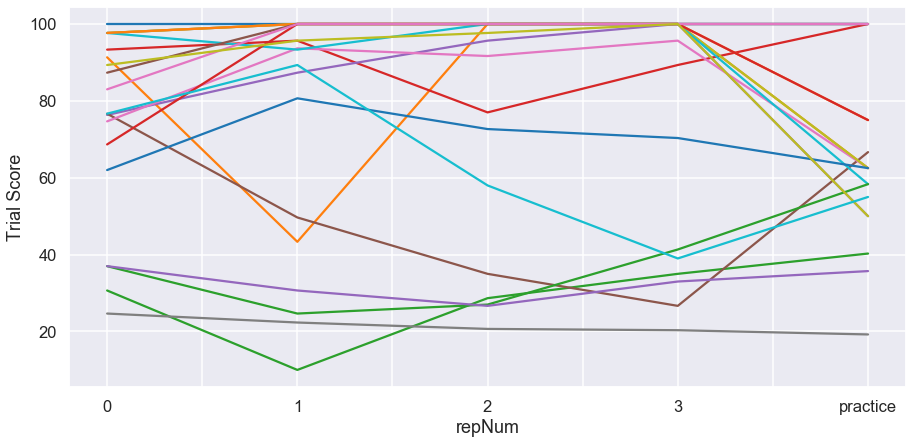

In [76]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['repNum','gameid'])['trialScore'].mean().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

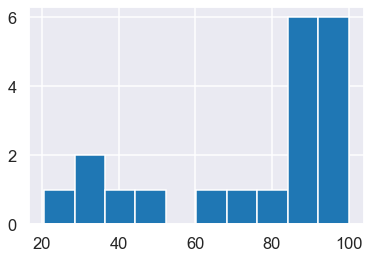

In [35]:
df_trial.groupby(['gameid'])['trialScore'].mean().hist()

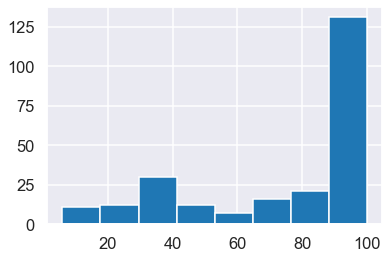

In [28]:
#Dist of trial scores:
(df_trial.groupby(['gameid','trialNum']).trialScore.max().hist(bins = 8))
plt.show()


In [29]:
pd.options.display.max_rows = 4000
df_trial.groupby(['gameid','trialNum']).trialScore.max()

gameid                                     trialNum
0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2  0.0         100.0
                                           1.0         100.0
                                           2.0         100.0
                                           3.0         100.0
                                           4.0         100.0
                                           5.0         100.0
                                           6.0         100.0
                                           7.0         100.0
                                           8.0         100.0
                                           9.0         100.0
                                           10.0        100.0
                                           11.0        100.0
1494-029e2297-bd3f-4cfe-be00-d06d36724e4e  0.0          87.0
                                           1.0         100.0
                                           2.0          87.0
                                 

In [ ]:
pd.DataFrame(df_trial[df_trial.trialNum>=0].groupby(['gameid']).trialScore.max())


### Architect: Distribution of words over trials

### Builder: Distribution of blocks placed per utterance


In [ ]:
(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count()).hist(bins = 8)
plt.show()


### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [ ]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

In [ ]:
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum()

In [ ]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

In [ ]:
## line plots: time for each builder
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['trialNum','gameid'])['timeElapsedInTurn'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Time elapsed in trial Builder')

In [ ]:
df_block.timeElapsedInTurn.min()

### Now, let's look at the DVs above, w.r.t. repetition of scenes, IGNORING which side a tower appears on... so across four repetitions (where [A,B] is equivalent to [B,A])

#### use rep num

In [ ]:
#
def convert(list): 
    return tuple(i for i in list)
df_chat['targetSet'] = convert(df_chat[['leftTarget', 'rightTarget']].values.tolist())

In [ ]:
df_chat.head(2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','targetSet'])['word_count'].sum().groupby(['targetSet']).mean().plot.bar(ax = ax)
plt.ylabel('Words Per figure')